In [ ]:
# Plot lexicon role probes

In [1]:
library(tidyverse)
library(fs)
library(ggtext)
library(systemfonts)
library(arrow)
library(patchwork)
library(ggtern)

ws = '/workspace/deliberative-alignment-jailbreaks'
model_prefix = 'gptoss20'

source(paste0(ws, '/r-utils/plots.r'))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp


--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplot_build, ggplot_gtable, ggplotGrob,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme

# Load data

In [34]:
raw_df =
    read_csv(file.path(ws, str_glue('experiments/role-analysis/projections/lexical-role-projections-{model_prefix}.csv')), trim_ws = FALSE) 
    
head(raw_df, 10)

Rows: 252 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): role_space, phrase, token
dbl (4): sample_ix, prob, prompt_ix, token_in_prompt_ix

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sample_ix,role_space,prob,prompt_ix,phrase,token_in_prompt_ix,token
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
951,system,0.00040598,0,The user says,951,The
952,system,0.00027894,0,The user says,952,user
953,system,0.00168111,0,The user says,953,says
1905,system,0.00058327,1,"But wait,",951,But
1906,system,0.00585161,1,"But wait,",952,wait
1907,system,0.00168463,1,"But wait,",953,","
2859,system,0.00123022,2,"Wait,",951,Wait
2860,system,0.00077752,2,"Wait,",952,","
3812,system,0.00092400,3,This is a,951,This


# Plots 1: Lexicon

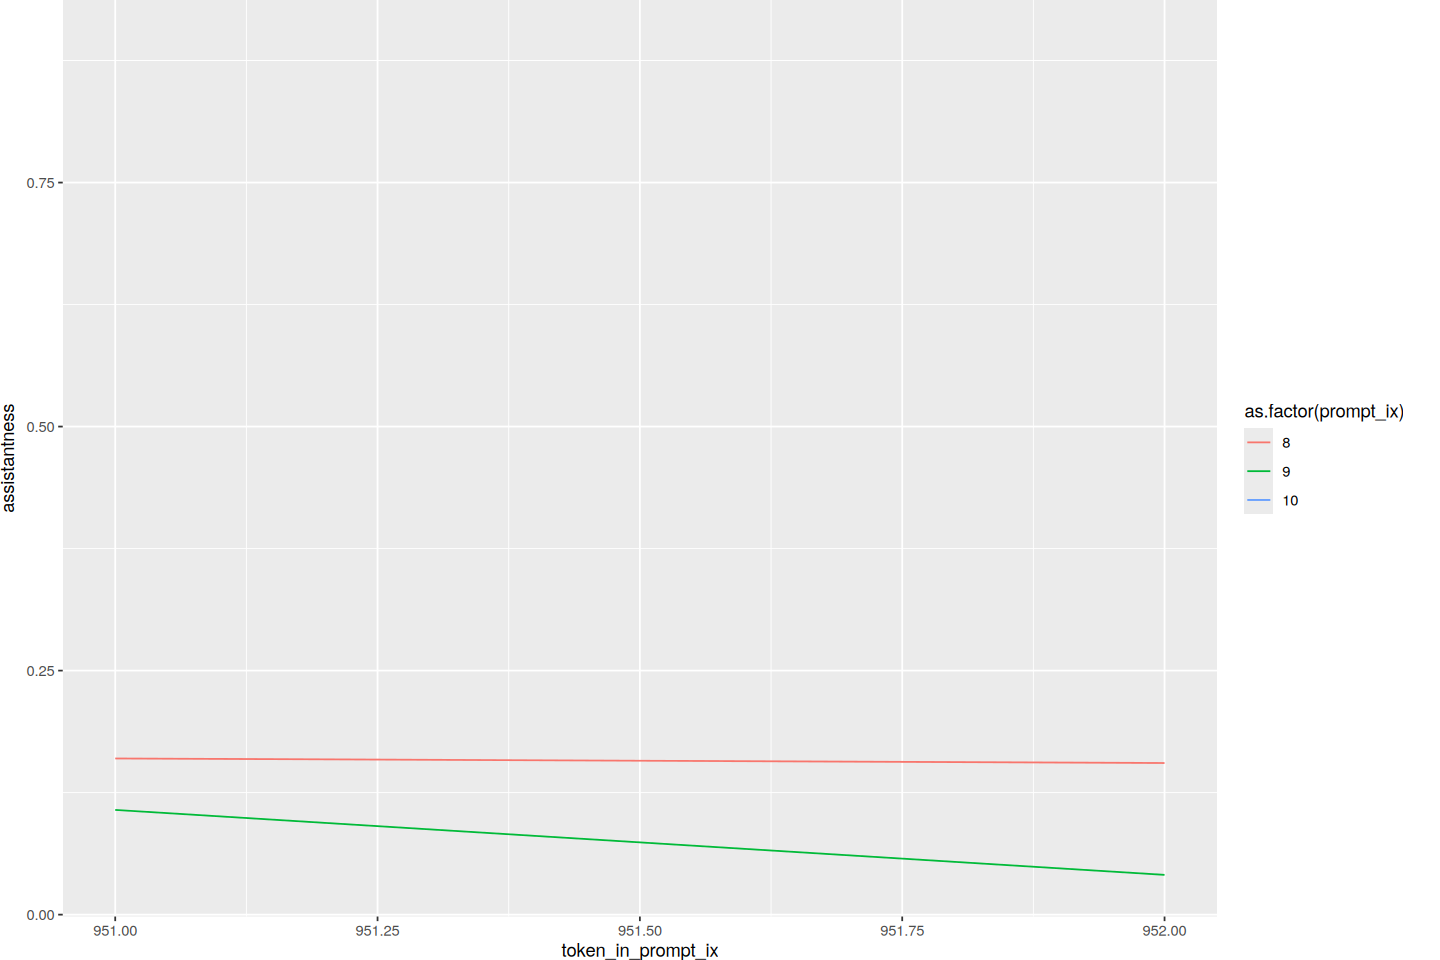

In [35]:
# Lex
options(repr.plot.width = 12, repr.plot.height = 8)

raw_df %>%
    filter(., role_space != 'system') %>%
    filter(., prompt_ix %in% 8:10) %>% 
    pivot_wider(id_cols = c(sample_ix, phrase, token, token_in_prompt_ix, prompt_ix), names_from = role_space, values_from = prob) %>%
    rename(userness = user, assistantness = 'assistant-final', cotness = 'assistant-cot') %>%
    group_by(prompt_ix) %>%
    mutate(., across(
        c(userness, assistantness, cotness),
        \(x) zoo::rollapply(x, seq_along(x), \(y) .5^(seq(length(y) - 1, 0)) %>% {sum(y * .)/sum(.)}, align = 'right', partial = T)
        )) %>%
    ungroup() %>%
    ggplot() + 
    geom_line(aes(x = token_in_prompt_ix, y = assistantness, color = as.factor(prompt_ix)))

In [36]:
raw_df %>%
    distinct(prompt_ix, phrase)


prompt_ix,phrase
<dbl>,<chr>
0,The user says
1,"But wait,"
2,"Wait,"
3,This is a
4,Let me
5,I need to provide
6,Here is
7,"Okay, the user"
8,The user


In [46]:
raw_df %>%
    filter(., role_space != 'system') %>%
    filter(., prompt_ix %in% 0:20) %>% 
    pivot_wider(id_cols = c(sample_ix, phrase, token, token_in_prompt_ix, prompt_ix), names_from = role_space, values_from = prob) %>%
    rename(userness = user, assistantness = 'assistant-final', cotness = 'assistant-cot') %>%
    group_by(prompt_ix) %>%
    mutate(., across(
        c(userness, assistantness, cotness),
        \(x) zoo::rollapply(x, seq_along(x), \(y) 0^(seq(length(y) - 1, 0)) %>% {sum(y * .)/sum(.)}, align = 'right', partial = T)
        )) %>%
    ungroup() %>%
    group_by(prompt_ix, phrase) %>%
    summarize(., userness = mean(userness), cotness = mean(cotness), assistantness = mean(assistantness), .groups = 'drop')


prompt_ix,phrase,userness,cotness,assistantness
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
0,The user says,0.34404425,0.511166450,0.14400063
1,"But wait,",0.43679259,0.075099530,0.48540138
2,"Wait,",0.64276226,0.088519220,0.26771471
3,This is a,0.74238482,0.045760000,0.20807758
4,Let me,0.50184795,0.168485330,0.32853829
5,I need to provide,0.81139958,0.077158535,0.11000197
6,Here is,0.86514267,0.027542225,0.10622866
7,"Okay, the user",0.31832847,0.519203507,0.16188570
8,The user,0.46497616,0.378208260,0.15647562


Warning message:
“Removing Layer 2 ('PositionNudge'), as it is not an approved position (for ternary plots) under the present ggtern package.”


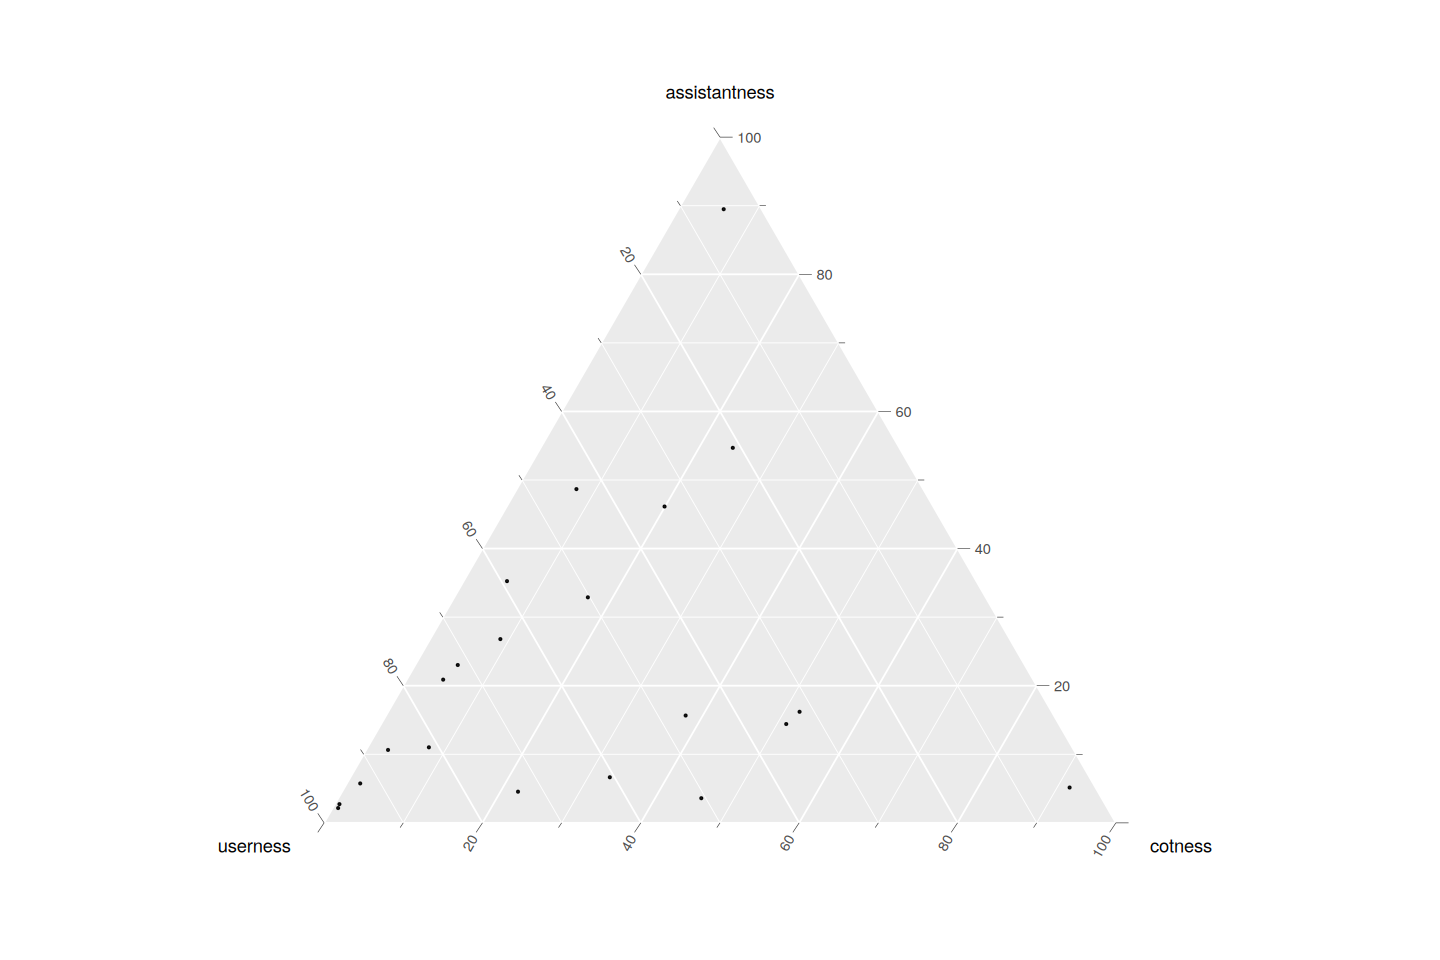

In [47]:
options(repr.plot.width = 12, repr.plot.height = 8)

raw_df %>%
    filter(., role_space != 'system') %>%
    filter(., prompt_ix %in% 0:20) %>% 
    pivot_wider(id_cols = c(sample_ix, phrase, token, token_in_prompt_ix, prompt_ix), names_from = role_space, values_from = prob) %>%
    rename(userness = user, assistantness = 'assistant-final', cotness = 'assistant-cot') %>%
    group_by(prompt_ix) %>%
    mutate(., across(
        c(userness, assistantness, cotness),
        \(x) zoo::rollapply(x, seq_along(x), \(y) 0^(seq(length(y) - 1, 0)) %>% {sum(y * .)/sum(.)}, align = 'right', partial = T)
        )) %>%
    ungroup() %>%
    group_by(prompt_ix, phrase) %>%
    summarize(., userness = mean(userness), cotness = mean(cotness), assistantness = mean(assistantness), .groups = 'drop') %>%
    ggtern(aes(x = userness, y = assistantness, z = cotness)) + # color = as.factor(prompt_ix),
    geom_point(size = .5, alpha = .9) +
    geom_text(aes(label = phrase)) +
    # geom_line(aes(group = prompt_ix), alpha = .2) +
    scale_color_viridis_c()


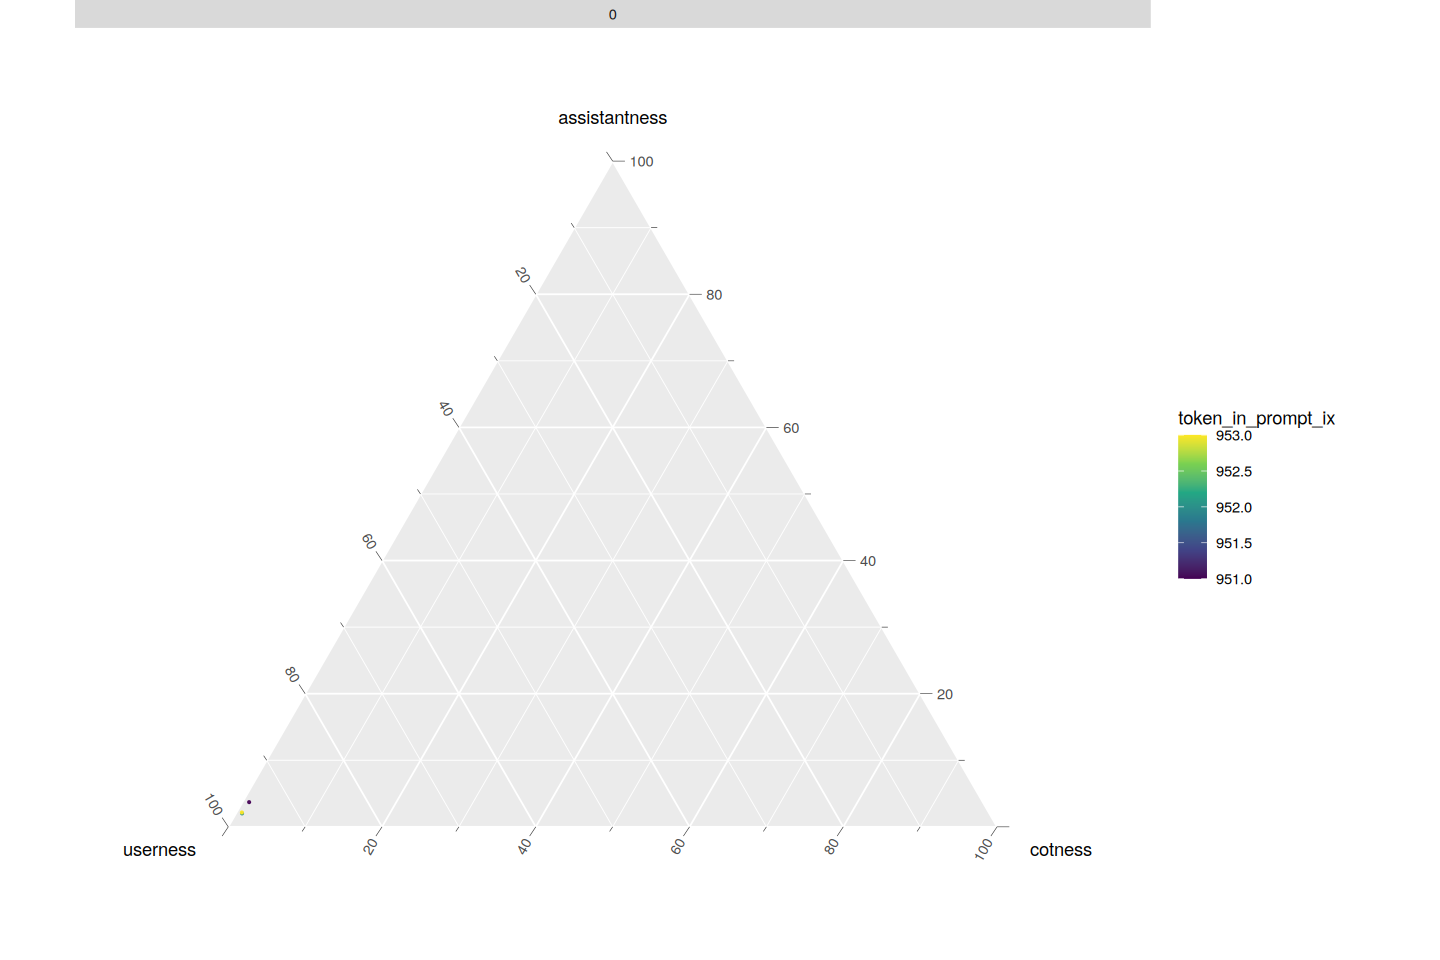

In [38]:
options(repr.plot.width = 12, repr.plot.height = 8)

raw_df %>%
    filter(., role_space != 'system') %>%
    filter(., prompt_ix %in% 13) %>%
    # EWMA
    group_by(prompt_ix, role_space) %>%
    arrange(token_in_prompt_ix, .by_group = T) %>%
    # mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .9^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    mutate(prob_ewma = zoo::rollmean(prob, k = 10, align = 'right', partial = T, fill = NA)) %>%
    ungroup() %>%
    # Renormalize to 1
    group_by(prompt_ix, token_in_prompt_ix) %>%
    mutate(., prob = prob/sum(prob), prob_ewma = prob_ewma/sum(prob_ewma)) %>%
    ungroup() %>%
    pivot_wider(id_cols = c(phrase, prompt_ix, token_in_prompt_ix, token, sample_ix), names_from = role_space, values_from = prob_ewma) %>%
    arrange(prompt_ix, token_in_prompt_ix) %>%
    rename(cotness = 'assistant-cot', assistantness = 'assistant-final', userness = 'user') %>%
    ggtern(aes(x = userness, y = assistantness, z = cotness, color = token_in_prompt_ix)) + # color = as.factor(prompt_ix),
    geom_point(size = .5, alpha = .9) +
    # geom_line(aes(group = prompt_ix), alpha = .2) +
    scale_color_viridis_c() +
    facet_wrap(vars(round(token_in_prompt_ix %/% 2000)), ncol = 3)


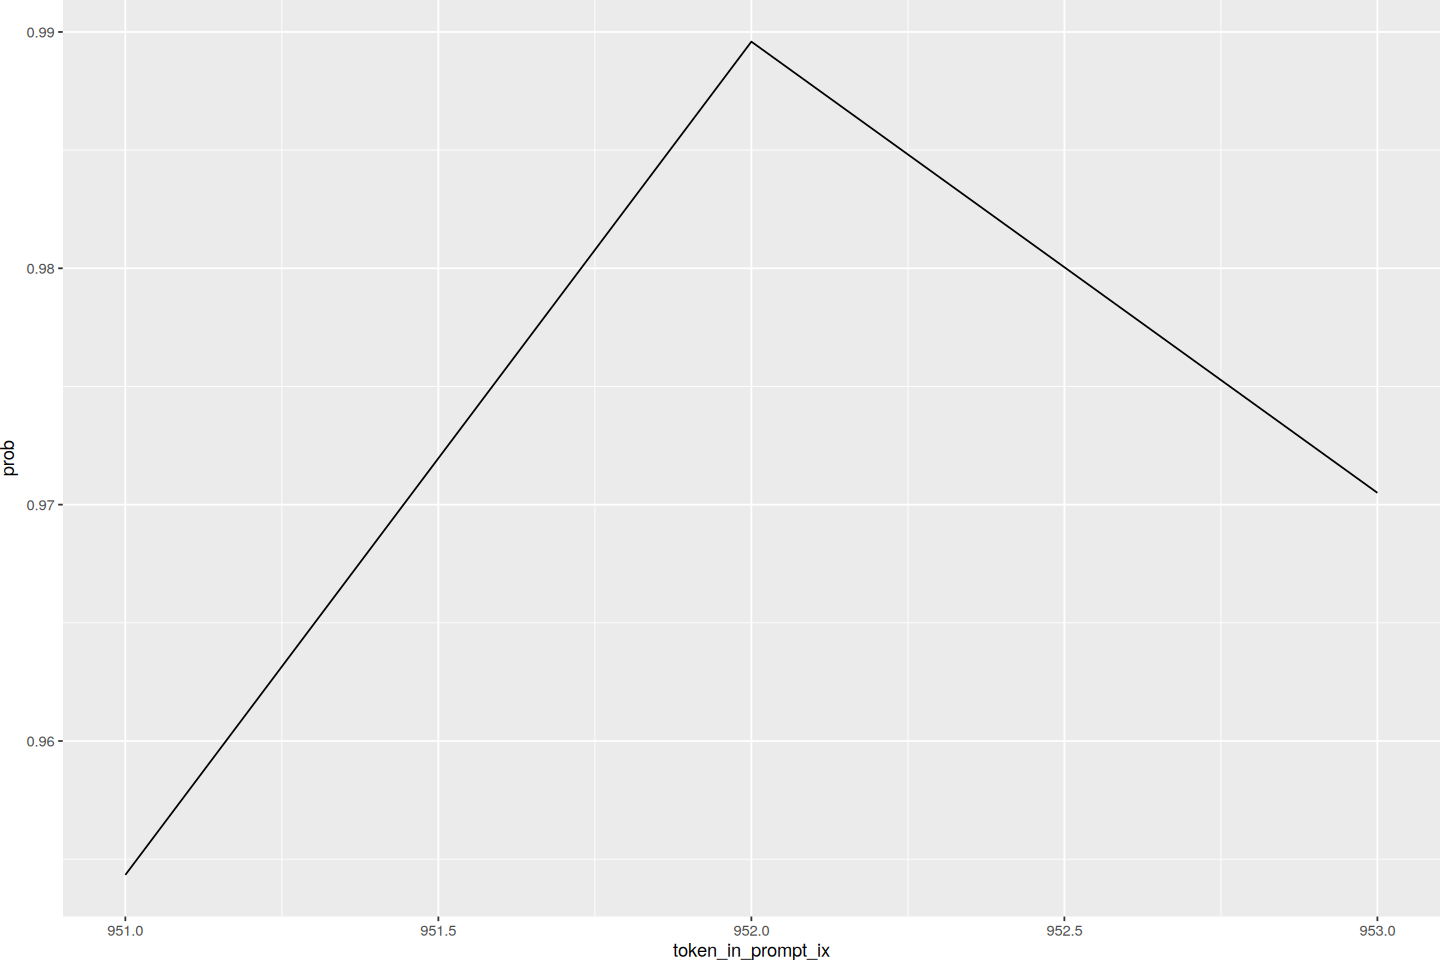

In [49]:
raw_df %>%
    filter(., role_space != 'system') %>%
    filter(., prompt_ix %in% 13) %>%
    # EWMA
    group_by(prompt_ix, role_space) %>%
    arrange(token_in_prompt_ix, .by_group = T) %>%
    # mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .9^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    mutate(prob_ewma = zoo::rollmean(prob, k = 20, align = 'right', partial = T, fill = NA)) %>%
    ungroup() %>%
    # Renormalize to 1
    group_by(prompt_ix, token_in_prompt_ix) %>%
    mutate(., prob = prob/sum(prob), prob_ewma = prob_ewma/sum(prob_ewma)) %>%
    ungroup() %>%
    filter(., role_space == 'user') %>% 
    ggplot() + 
    geom_line(aes(x = token_in_prompt_ix, y = prob))

In [ ]:
raw_df %>%
    filter(., role_space != 'system') %>%
    filter(., prompt_ix %in% 13) %>%
    # EWMA
    group_by(prompt_ix, role_space) %>%
    arrange(token_in_prompt_ix, .by_group = T) %>%
    select(-phrase) %>%
    mutate(
        .,    
    )

Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.


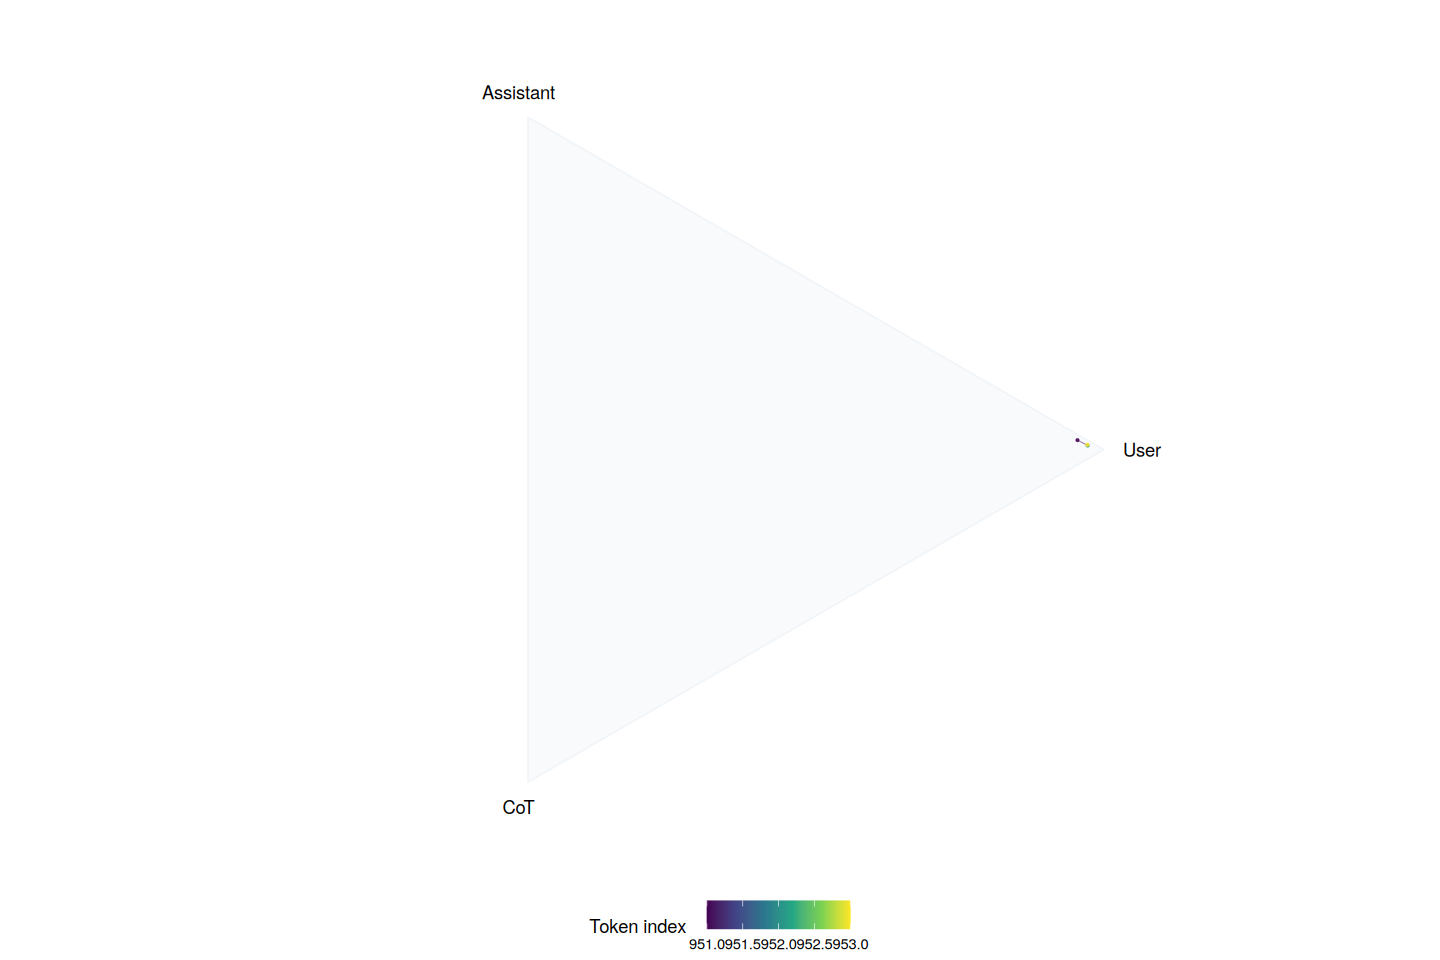

In [50]:
df_wheel =
    raw_df %>%
    filter(role_space != "system") %>%
    filter(prompt_ix %in% 13) %>%
    # EWMA over tokens within each role
    group_by(prompt_ix, role_space) %>%
    arrange(token_in_prompt_ix, .by_group = TRUE) %>%
    # mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .9^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    mutate(prob_ewma = zoo::rollmean(prob, k = 20, align = 'right', partial = T, fill = NA)) %>%
    ungroup() %>%
    # Renormalize to 1
    group_by(prompt_ix, token_in_prompt_ix) %>%
    mutate(., prob = prob/sum(prob), prob_ewma = prob_ewma/sum(prob_ewma)) %>%
    ungroup() %>%
    pivot_wider(id_cols = c(phrase, prompt_ix, token_in_prompt_ix, token, sample_ix), names_from = role_space, values_from = prob_ewma) %>%
    arrange(prompt_ix, token_in_prompt_ix) %>%
    rename(cotness = 'assistant-cot', assistantness = 'assistant-final', userness = 'user') %>%
    mutate(
        angle = atan2(
        (sqrt(3) / 2) * (assistantness - cotness),          # “y-like” term
        userness - 0.5 * (assistantness + cotness)          # “x-like” term
    ),
    # Max-prob purity
    # m = pmax(userness, assistantness, cotness),
    # purity = (3*m - 1)/2,
    # L2 distance from center
    sum_sq = userness^2 + assistantness^2 + cotness^2,
    purity = sqrt(1.5 * (sum_sq - 1/3)),
    # Gini
    # purity =  (3*sum_sq - 1) / 2,
    # Entropy
    # H = -(userness*log(userness) + assistantness*log(assistantness) + cotness*log(cotness)),
    # purity = 1 - H / log(3),

    x = purity * cos(angle),
    y = purity * sin(angle)
)

circle_df = tibble(t = seq(0, 2 * pi, length.out = 361), x = cos(t), y = sin(t))
triangle_df = tibble(
    x = c(1, cos(2*pi/3), cos(4*pi/3), 1),
    y = c(0, sin(2*pi/3), sin(4*pi/3), 0)
)



ggplot(df_wheel, aes(x = x, y = y, colour = token_in_prompt_ix)) +
    # geom_polygon(data = circle_df, aes(x, y), inherit.aes = FALSE, linewidth = 0.5, fill = '#f8fafc', color = '#f1f5f9') +

    geom_polygon(data = triangle_df, aes(x, y), inherit.aes = FALSE, linewidth = 0.5, fill = '#f8fafc', color = '#f1f5f9') +
    geom_path(aes(group = prompt_ix), alpha = 0.5, linewidth = 0.3) +
    geom_point(size = 0.5, alpha = 0.8) +
    # Make it look like a disc
    coord_equal(xlim = c(-1.05, 1.05), ylim = c(-1.05, 1.05), expand = 0) +
    theme_void() +
    # Label the three role directions just outside the circle
    coord_equal(xlim = c(-1.15, 1.15), ylim = c(-1.15, 1.15), expand = 0) +
    scale_color_viridis_c( name = "Token index")  +  # uncomment if you want a different Viridis palette
    theme_void(base_size = 11) +
    theme(legend.position = "bottom", plot.margin = margin(5, 5, 5, 5)) +
    annotate("text", x = 1.05, y = 0, label = "User", hjust = 0, vjust = 0.5) +
    annotate("text", x = cos(2*pi/3) * 1.05, y = sin(2*pi/3) * 1.05, label = "Assistant", hjust = 0.5, vjust = -0.1) +
    annotate("text", x = cos(4*pi/3) * 1.05, y = sin(4*pi/3) * 1.05, label = "CoT", hjust = 0.5, vjust = 1.1)


In [ ]:
df_wheel <- raw_df %>%
    filter(role_space != "system") %>%
    filter(prompt_ix %in% 12) %>%
    # EWMA over tokens within each role
    group_by(prompt_ix, role_space) %>%
    arrange(token_in_prompt_ix, .by_group = TRUE) %>%
    # mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .9^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    mutate(prob_ewma = zoo::rollmean(prob, k = 20, align = 'right', partial = T, fill = NA)) %>%
    ungroup() %>%
    # Renormalize to 1
    group_by(prompt_ix, token_in_prompt_ix) %>%
    mutate(., prob = prob/sum(prob), prob_ewma = prob_ewma/sum(prob_ewma)) %>%
    ungroup() %>%
    pivot_wider(id_cols = c(phrase, prompt_ix, token_in_prompt_ix, token, sample_ix), names_from = role_space, values_from = prob_ewma) %>%
    arrange(prompt_ix, token_in_prompt_ix) %>%
    rename(cotness = 'assistant-cot', assistantness = 'assistant-final', userness = 'user') %>%


In [ ]:
df_wheel <- raw_df %>%
    filter(role_space != "system") %>%
    filter(prompt_ix %in% 12) %>%
    # EWMA over tokens within each role
    group_by(prompt_ix, role_space) %>%
    arrange(token_in_prompt_ix, .by_group = TRUE) %>%
    # mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .9^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    mutate(prob_ewma = zoo::rollmean(prob, k = 20, align = 'right', partial = T, fill = NA)) %>%
    ungroup() %>%
    # Renormalize to 1
    group_by(prompt_ix, token_in_prompt_ix) %>%
    mutate(., prob = prob/sum(prob), prob_ewma = prob_ewma/sum(prob_ewma)) %>%
    ungroup() %>%
    pivot_wider(id_cols = c(phrase, prompt_ix, token_in_prompt_ix, token, sample_ix), names_from = role_space, values_from = prob_ewma) %>%
    arrange(prompt_ix, token_in_prompt_ix) %>%
    rename(cotness = 'assistant-cot', assistantness = 'assistant-final', userness = 'user') %>%
      # --- map simplex -> unit disc (3 directions 120° apart) ---
mutate(
  angle = atan2(
    (sqrt(3) / 2) * (assistantness - cotness),          # “y-like” term
    userness - 0.5 * (assistantness + cotness)          # “x-like” term
  ),
  purity = pmax(userness^2 + assistantness^2 + cotness^2),
  # purity = pmax(userness, assistantness, cotness),
  x = purity * cos(angle),
  y = purity * sin(angle)
)

# outline of the unit circle for aesthetics
circle_df <- tibble(
t = seq(0, 2 * pi, length.out = 361),
x = cos(t),
y = sin(t)
)

ggplot(df_wheel, aes(x = x, y = y, colour = token_in_prompt_ix)) +
  # circle boundary
  geom_path(
    data = circle_df,
    aes(x, y),
    inherit.aes = FALSE,
    linewidth = 0.4
  ) +
  # trajectory + points
  geom_path(aes(group = prompt_ix), alpha = 0.5, linewidth = 0.3) +
  geom_point(size = 0.5, alpha = 0.8) +
  # make it look like a true disc
  coord_equal(xlim = c(-1.05, 1.05),
              ylim = c(-1.05, 1.05),
              expand = 0) +
  theme_void() +
  scale_color_viridis_c() +
  # label the three role directions just outside the circle
  annotate("text", x = 1.1, y = 0, label = "User") +
  annotate("text", x = cos(2*pi/3)*1.1,  y = sin(2*pi/3)*1.1, label = "Assistant") +
  annotate("text", x = cos(4*pi/3)*1.1,  y = sin(4*pi/3)*1.1, label = "CoT")


In [ ]:
# raw_df %>%
#     filter(., role_space != 'system') %>%
#     filter(., prompt_ix %in% 12) %>%
#     # EWMA
#     group_by(prompt_ix, role_space) %>%
#     arrange(token_in_prompt_ix, .by_group = T) %>%
#     mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .5^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
#     ungroup() %>%
#     # Renormalize to 1
#     group_by(prompt_ix, token_in_prompt_ix) %>%
#     mutate(., prob = prob/sum(prob), prob_ewma = prob_ewma/sum(prob_ewma)) %>%
#     ungroup() %>%
#     pivot_wider(id_cols = c(phrase, prompt_ix, token_in_prompt_ix, token, sample_ix), names_from = role_space, values_from = prob_ewma) %>%
#     arrange(prompt_ix, token_in_prompt_ix) 

In [ ]:
raw_df %>% distinct(prompt_ix, phrase)

In [ ]:
raw_df %>% distinct(prompt_ix, phrase)

In [ ]:
cite(ggtern)